In [ ]:
import os
import glob
import numpy as np
import rasterio
from rasterstats import zonal_stats
import geopandas as gpd

# 1. 读取摩洛哥省级边界
shp_path = '/content/drive/MyDrive/shp/final map/MAR.shp'
gdf = gpd.read_file(shp_path)

# 2. 列出所有 GPP 文件
tif_files = sorted(glob.glob('/content/drive/MyDrive/GEE_GPP_Morocco/GPP_*.tif'))

# 3. 计算不同月份的最值
gpp_min = {}
gpp_max = {}

for month in range(1, 13):
    min_list, max_list = [], []

    # 计算最值的时间范围
    if month in [11, 12]:  # 11月、12月使用 2000-2022 年
        start_year, end_year = 2000, 2022
    elif month in [1, 2, 3, 4, 5, 6, 7]:  # 1-7月使用 2001-2023 年
        start_year, end_year = 2001, 2023
    else:  # 8-10月使用 2001-2022 年
        start_year, end_year = 2001, 2022

    # 筛选符合时间范围的文件
    selected_files = [
        tif for tif in tif_files if int(os.path.basename(tif).split('_')[1]) in range(start_year, end_year + 1)
        and int(os.path.basename(tif).split('_')[2].replace('.tif', '')) == month
    ]

    # 计算最小值和最大值
    for tif in selected_files:
        with rasterio.open(tif) as raster:
            data = raster.read(1).astype(float)
            data[data == raster.nodata] = np.nan  # 处理无效值
            min_list.append(data)
            max_list.append(data)

    if min_list and max_list:  # 确保列表不为空
        gpp_min[month] = np.nanmin(np.stack(min_list), axis=0)
        gpp_max[month] = np.nanmax(np.stack(max_list), axis=0)
    else:
        print(f"警告: 没有找到 {month} 月的有效 GPP 数据，跳过该月份。")
        gpp_min[month] = None
        gpp_max[month] = None

# 4. 计算 anomaly 并进行 zonal 统计
results = []

for tif in tif_files:
    base = os.path.basename(tif)
    parts = base.replace('.tif', '').split('_')
    year, month = int(parts[1]), int(parts[2])

    with rasterio.open(tif) as raster:
        data = raster.read(1).astype(float)
        data[data == raster.nodata] = np.nan  # 处理 nodata
        affine = raster.transform  # 提取仿射变换信息

    # 获取该月份的最值
    gpp_min_img = gpp_min.get(month, None)
    gpp_max_img = gpp_max.get(month, None)

    if gpp_min_img is None or gpp_max_img is None:
        print(f"跳过 {year}-{month}，因为没有对应的最值。")
        continue

    # 计算 anomaly
    mask = ~np.isnan(data) & (gpp_max_img > gpp_min_img)  # 避免除零
    anomaly = np.where(mask, (data - gpp_min_img) / (gpp_max_img - gpp_min_img), np.nan)

    # 创建临时栅格文件
    temp_tif = "/content/temp_anomaly.tif"
    with rasterio.open(
        temp_tif, "w", driver="GTiff", height=data.shape[0], width=data.shape[1],
        count=1, dtype=rasterio.float32, crs=raster.crs, transform=affine
    ) as dst:
        dst.write(anomaly, 1)

    # 计算省级 anomaly 平均值
    stats = zonal_stats(gdf, temp_tif, stats='mean', nodata=np.nan)

    for idx, stat in enumerate(stats):
        province_name = gdf.iloc[idx]['NAME_2'] if 'NAME_2' in gdf.columns else gdf.iloc[idx]['NAME']
        results.append({
            'Province': province_name,
            'Year': year,
            'Month': month,
            'Anomaly_GPP': stat['mean'] if stat['mean'] is not None else np.nan
        })

# 5. 结果保存
import pandas as pd
df = pd.DataFrame(results)
df.to_csv('/content/drive/MyDrive/GPP_Anomaly_by_province.csv', index=False)
print("计算完成，结果已保存。")



<ipython-input-5-a77595906711>:45: RuntimeWarning: All-NaN slice encountered
  gpp_min[month] = np.nanmin(np.stack(min_list), axis=0)
<ipython-input-5-a77595906711>:46: RuntimeWarning: All-NaN slice encountered
  gpp_max[month] = np.nanmax(np.stack(max_list), axis=0)
<ipython-input-5-a77595906711>:75: RuntimeWarning: invalid value encountered in divide
  anomaly = np.where(mask, (data - gpp_min_img) / (gpp_max_img - gpp_min_img), np.nan)
<ipython-input-5-a77595906711>:75: RuntimeWarning: invalid value encountered in divide
  anomaly = np.where(mask, (data - gpp_min_img) / (gpp_max_img - gpp_min_img), np.nan)
<ipython-input-5-a77595906711>:75: RuntimeWarning: invalid value encountered in divide
  anomaly = np.where(mask, (data - gpp_min_img) / (gpp_max_img - gpp_min_img), np.nan)
<ipython-input-5-a77595906711>:75: RuntimeWarning: invalid value encountered in divide
  anomaly = np.where(mask, (data - gpp_min_img) / (gpp_max_img - gpp_min_img), np.nan)
<ipython-input-5-a77595906711>:75: R

计算完成，结果已保存。


下面是之前的代码，anomoly计算错误

In [ ]:
import os
import glob
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd

# 1. 读取摩洛哥省级边界 shapefile
shp_path = '/content/drive/MyDrive/shp/final map/MAR.shp'
gdf = gpd.read_file(shp_path)

# 2. 列出所有 GPP 文件（假设命名格式为 GPP_YYYY_MM.tif）
tif_files = sorted(glob.glob('/content/drive/MyDrive/GEE_GPP_Morocco/GPP_*.tif'))

# 用于存放结果的列表
results = []

# 3. 处理每个 GPP tif 文件
for tif in tif_files:
    # 提取年份和月份信息，如 "GPP_2000_10.tif"
    base = os.path.basename(tif)
    name_parts = base.replace('.tif', '').split('_')
    # 确保文件名结构正确，例如：['GPP', '2000', '10']
    if len(name_parts) < 3:
        print(f"文件名 {base} 不符合预期的格式，跳过处理。")
        continue  # 跳过格式不正确的文件
    year = name_parts[1]  # 修改索引为1
    month = name_parts[2]  # 修改索引为2

    # 计算每个省的平均 GPP 值
    stats = zonal_stats(gdf, tif, stats='mean', nodata=-9999)

    # 将统计结果添加到结果列表
    for idx, stat in enumerate(stats):
        province_name = gdf.iloc[idx]['NAME_2'] if 'NAME_2' in gdf.columns else gdf.iloc[idx]['NAME']
        results.append({
            'Province': province_name,
            'Year': year,
            'Month': month,
            'GPP_mean': stat['mean'] if stat['mean'] is not None else None  # 处理可能的空值
        })

# 4. 结果转换为 DataFrame 并导出
df = pd.DataFrame(results)
output_csv = '/content/drive/MyDrive/GPP_monthly_by_province.csv'
df.to_csv(output_csv, index=False)
print("结果已保存到:", output_csv)

结果已保存到: /content/drive/MyDrive/GPP_monthly_by_province.csv


转化/content/drive/MyDrive/GPP_Anomaly_by_province.csv 为长格式

In [ ]:
import pandas as pd

# 读取 CSV 文件
file_path = "/content/drive/MyDrive/GPP_Anomaly_by_province.csv"
df = pd.read_csv(file_path)

# 创建新的 'Year-Month' 列
df["Year-Month"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)

# 转换为宽格式
df_pivot = df.pivot(index="Year-Month", columns="Province", values="Anomaly_GPP")

# 重置列索引，使 'Year-Month' 成为第一列
df_pivot.reset_index(inplace=True)

# 导出结果
output_path = "/content/drive/MyDrive/GPP_Anomaly_by_province_wide.csv"
df_pivot.to_csv(output_path, index=False)

print("转换完成，文件已保存到:", output_path)



转换完成，文件已保存到: /content/drive/MyDrive/GPP_Anomaly_by_province_wide.csv


<ipython-input-10-f2dc0eda321e>:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # 调整布局以留出颜色条空间


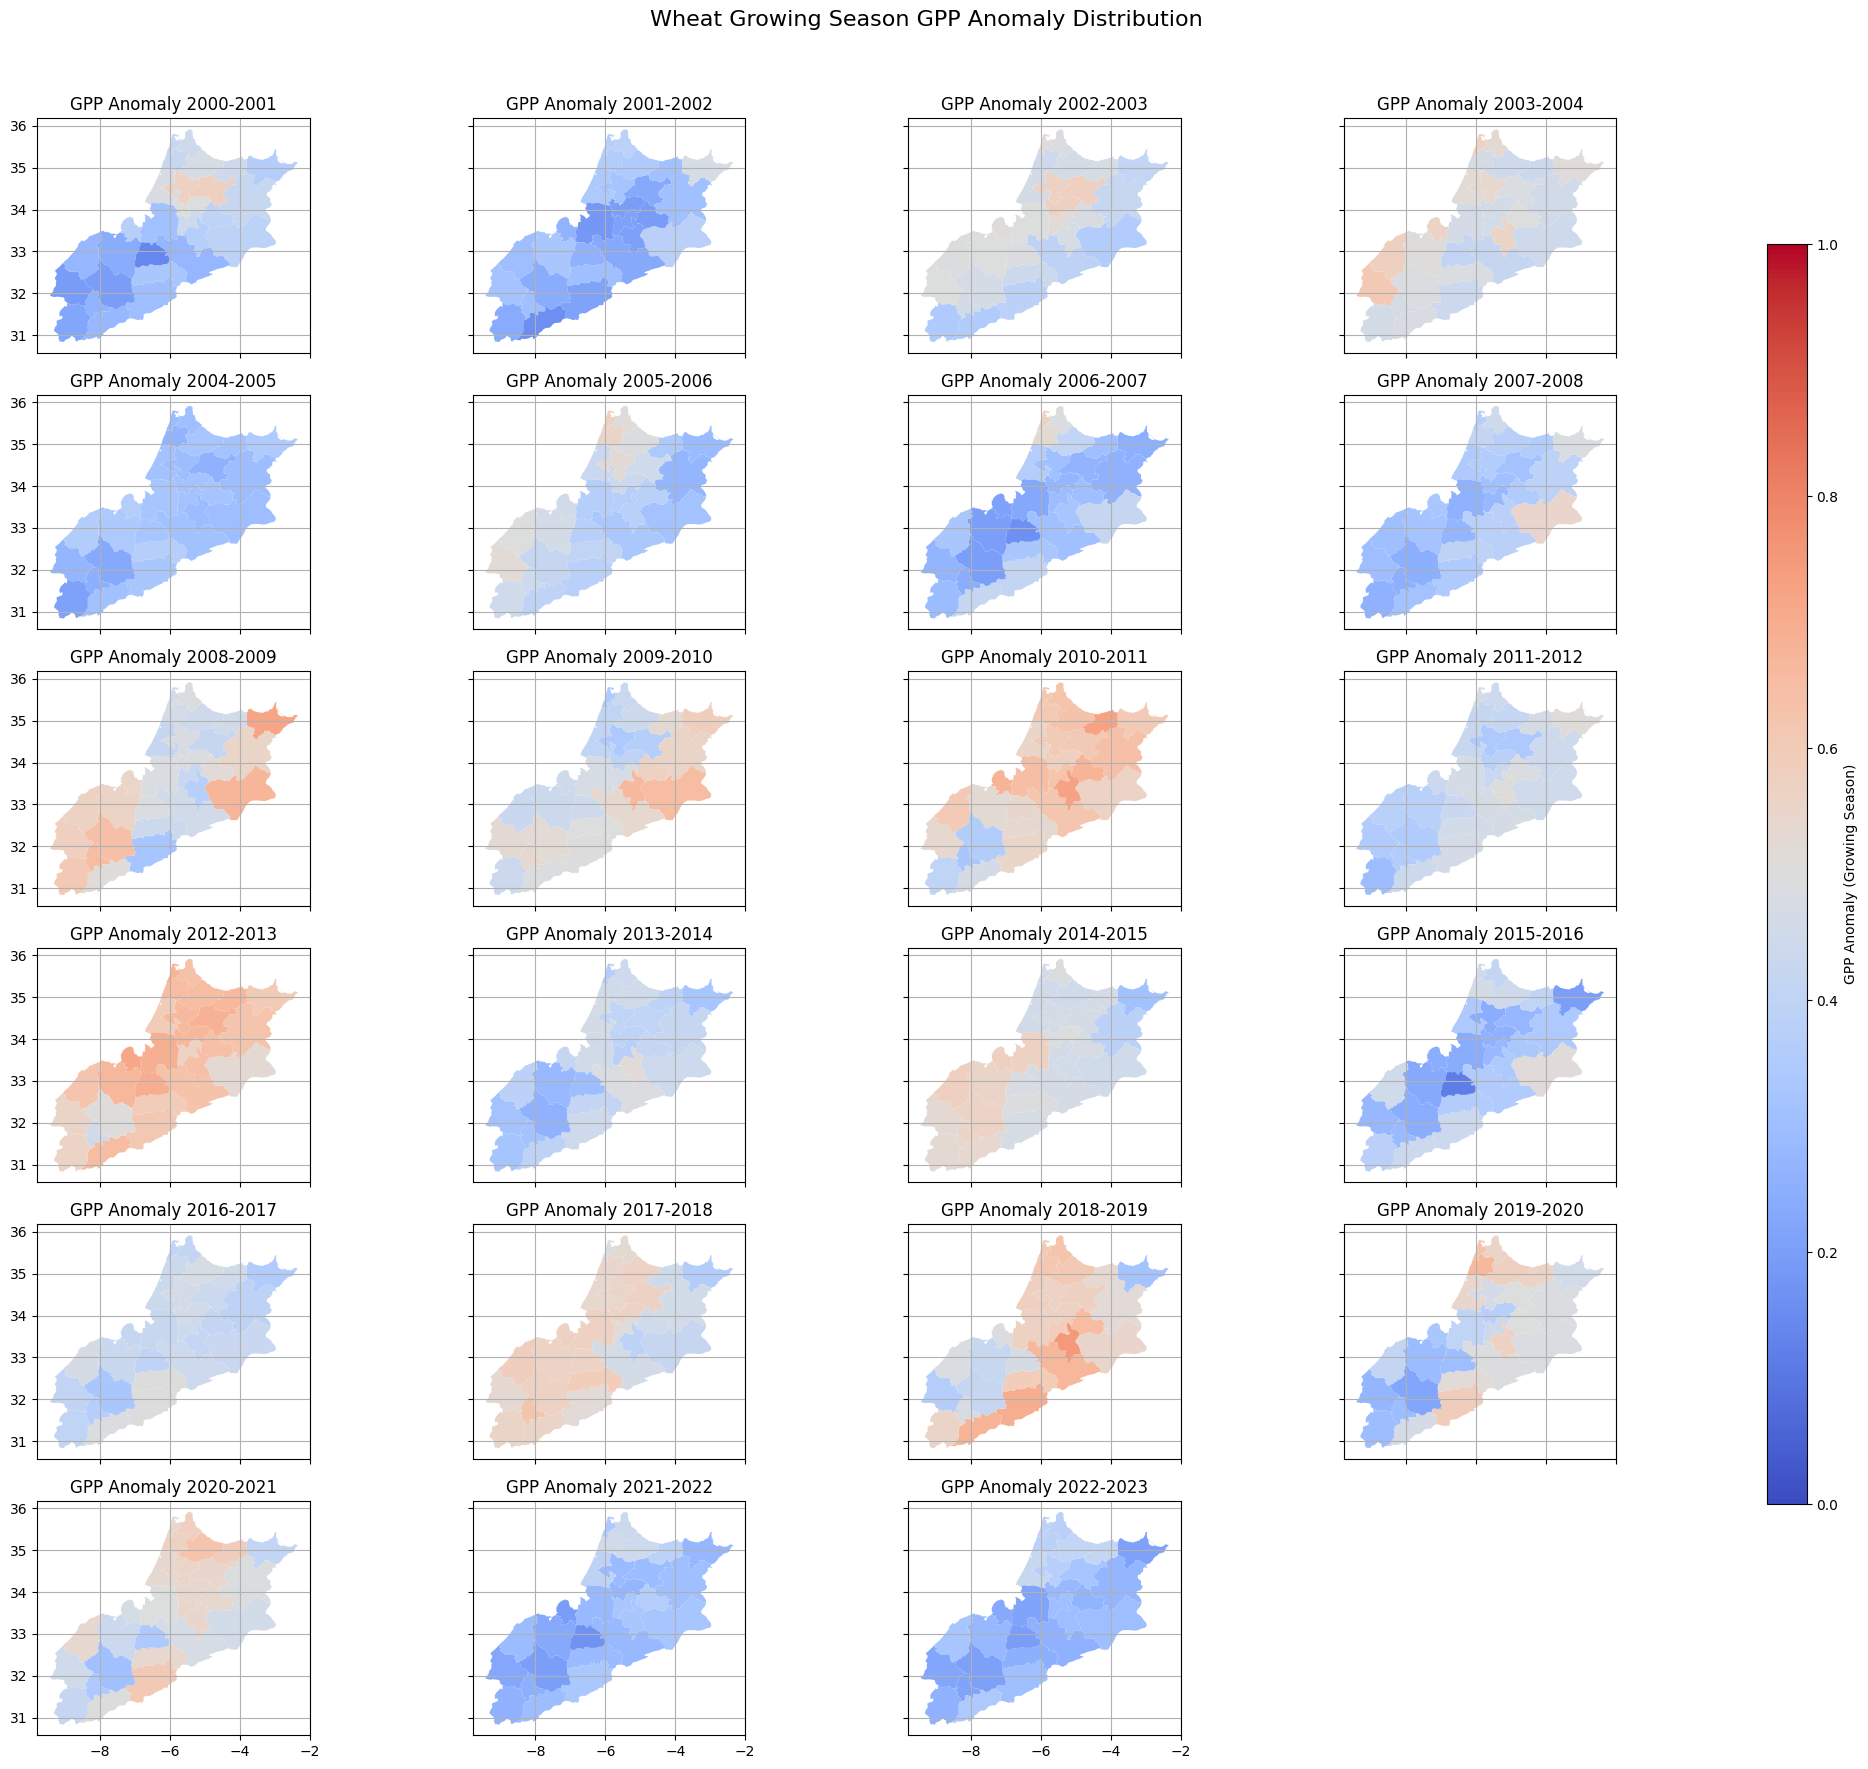

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 读取 Shapefile
shapefile_path = "/content/drive/MyDrive/shp/final map/MAR.shp"
gdf = gpd.read_file(shapefile_path)

# 读取 GPP 异常值数据
gpp_csv_path = "/content/drive/MyDrive/GPP_Anomaly_by_province_wide.csv"
gpp_df = pd.read_csv(gpp_csv_path)

# 将 'Year-Month' 拆分为 'Year' 和 'Month'
gpp_df[['Year', 'Month']] = gpp_df['Year-Month'].str.split('-', expand=True)
gpp_df['Year'] = gpp_df['Year'].astype(int)
gpp_df['Month'] = gpp_df['Month'].astype(int)

# 计算生长季的 GPP 平均值（11月至6月）
gpp_df['Growing_Season_Year'] = gpp_df.apply(lambda row: row['Year'] if row['Month'] >= 11 else row['Year'] - 1, axis=1)

# 转换数据为长格式（Long Format）
gpp_melted = gpp_df.melt(id_vars=['Year-Month', 'Year', 'Month', 'Growing_Season_Year'],
                          var_name='Province',
                          value_name='GPP_anomaly')

# 筛选生长季数据
growing_season_df = gpp_melted[gpp_melted['Month'].isin([11, 12, 1, 2, 3, 4, 5, 6])]

# 计算生长季的年度平均 GPP 异常值
seasonal_avg_gpp_df = growing_season_df.groupby(['Province', 'Growing_Season_Year'])['GPP_anomaly'].mean().reset_index()
seasonal_avg_gpp_df.rename(columns={'Growing_Season_Year': 'Year'}, inplace=True)

# 合并 Shapefile 数据和计算出的 GPP 异常值
gdf = gdf.merge(seasonal_avg_gpp_df, left_on='NAME_2', right_on='Province', how='left')

# 获取2000/2001到2022/2023的年份范围
years = [year for year in range(2000, 2023)]

# 设置颜色映射
gpp_vmin, gpp_vmax = 0, 1
cmap = 'coolwarm'
norm = mcolors.Normalize(vmin=gpp_vmin, vmax=gpp_vmax)

# 设置子图布局
cols = 4
rows = (len(years) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), sharex=True, sharey=True)

# 绘制每年的生长季 GPP 异常值数据
for i, year in enumerate(years):
    ax = axes.flatten()[i]  # 获取对应的子图
    year_data = gdf[gdf['Year'] == year]

    if year_data.empty:
        ax.set_visible(False)
        continue

    year_data.plot(column='GPP_anomaly', ax=ax, cmap=cmap, norm=norm, legend=False)
    ax.set_title(f"GPP Anomaly {year}-{year+1}")
    ax.grid(True)

# 隐藏多余的子图
for ax in axes.flatten()[len(years):]:
    ax.set_visible(False)

# 添加全局颜色条
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # 颜色条位置调整
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(sm, cax=cbar_ax, label='GPP Anomaly (Growing Season)')

fig.suptitle("Wheat Growing Season GPP Anomaly Distribution", fontsize=18)
plt.subplots_adjust(wspace=0.05, hspace=0.2, right=0.89, top=0.94)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/GPP_anomaly_output/Provincial_GPP_Grid1.png'

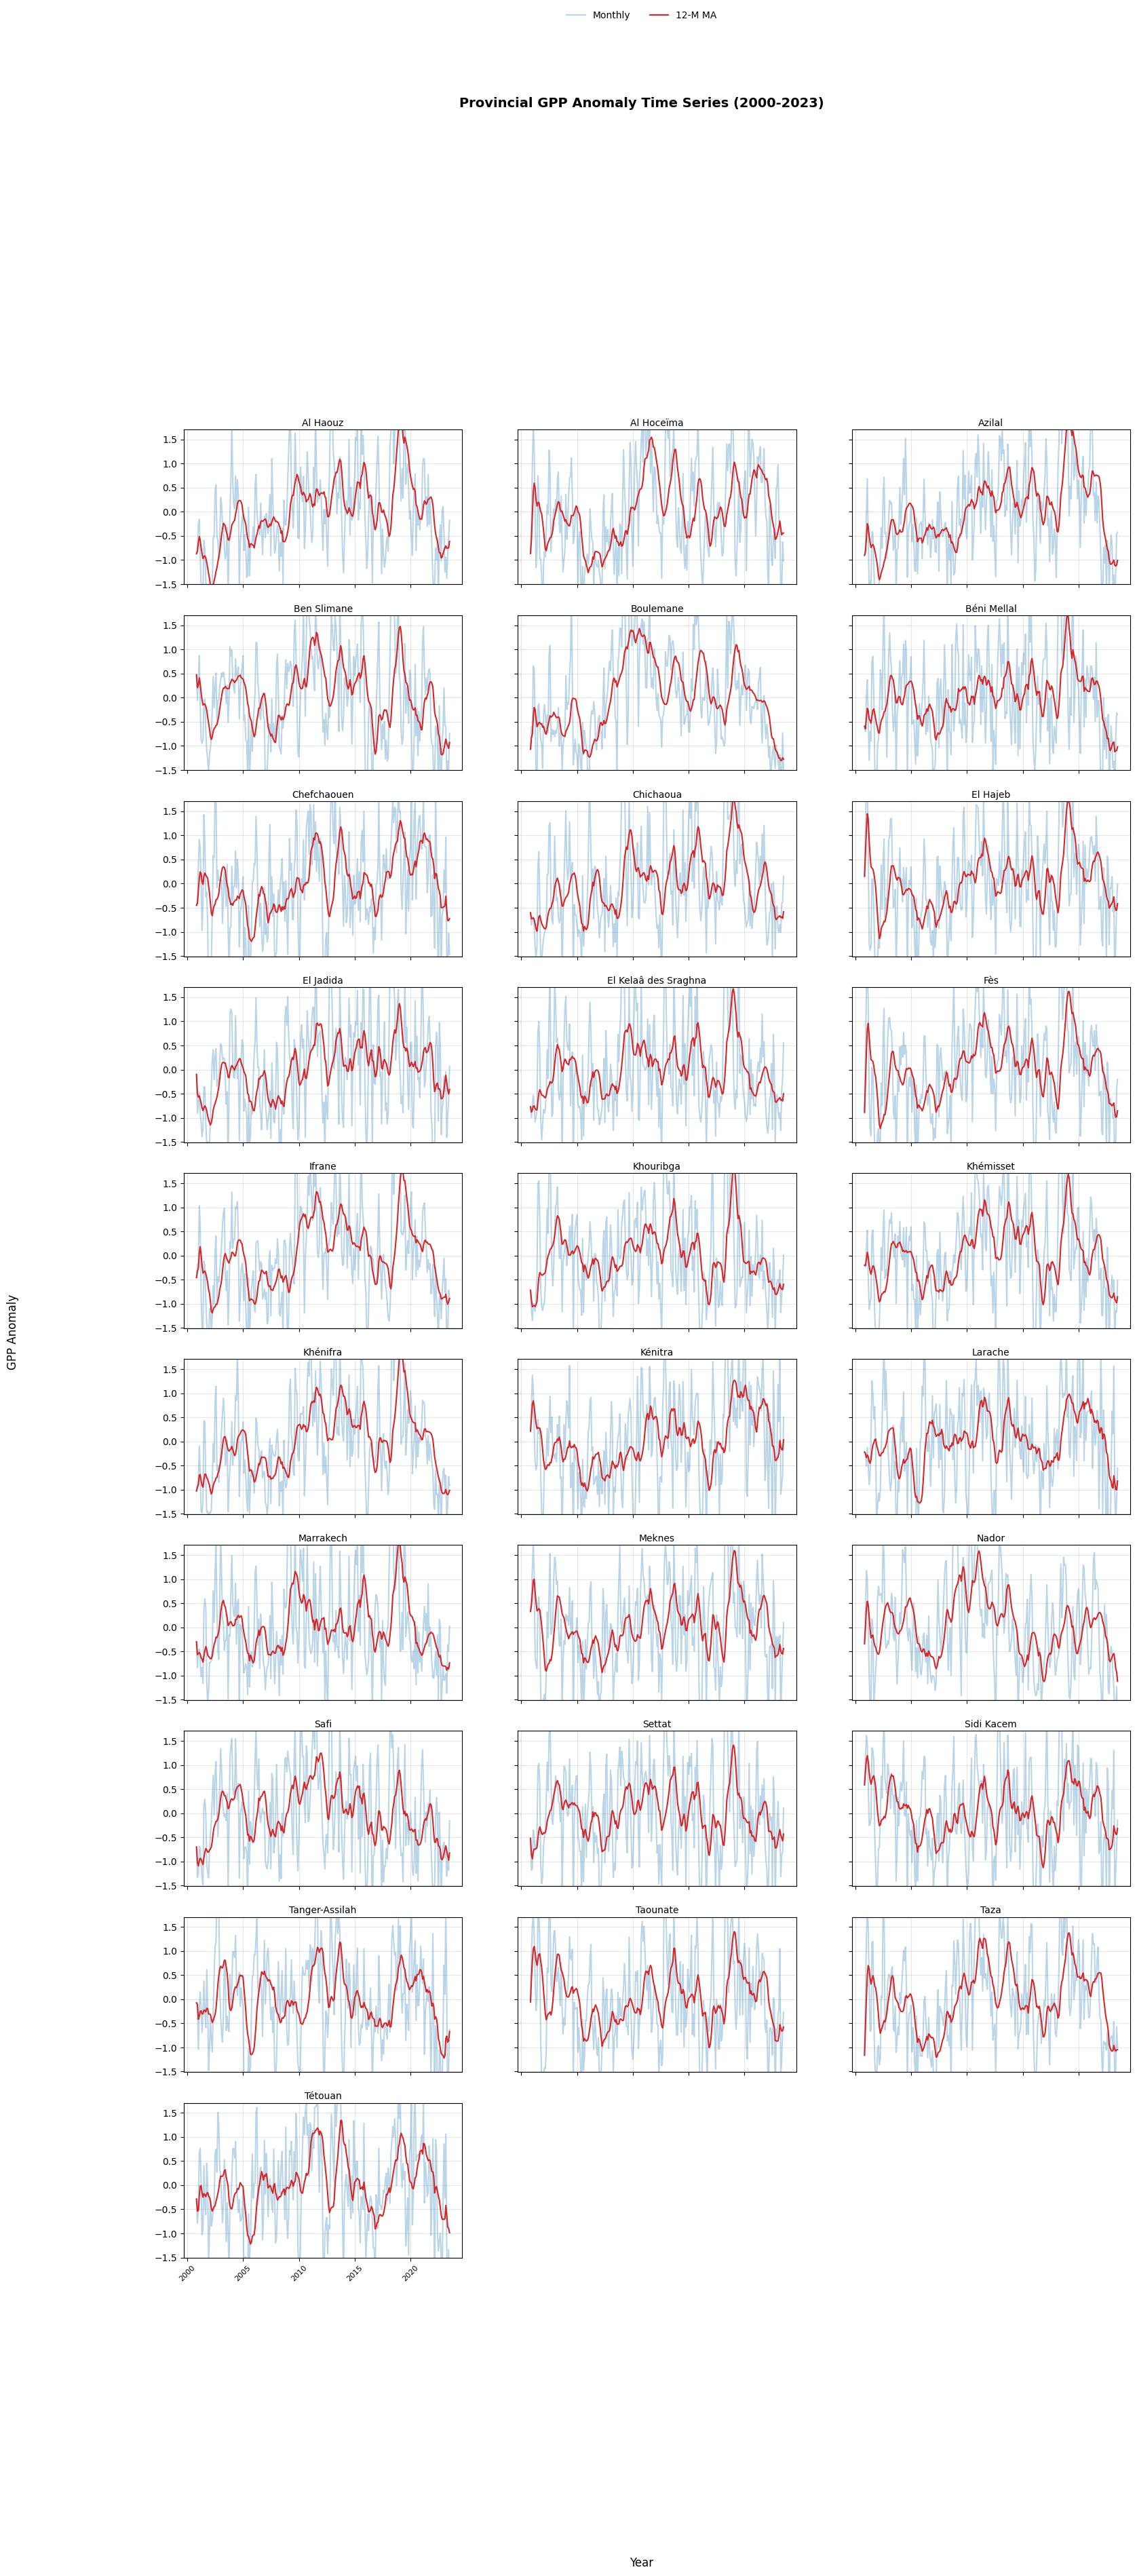

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 读取 CSV 文件
df = pd.read_csv("/content/drive/MyDrive/GPP_anomaly_monthly.csv")

# 解析 "Year-Month" 列为 datetime 格式
df['Date'] = pd.to_datetime(df['Year-Month'], format='%Y-%m')

# 转换列数据：将省份列变成行
df = df.melt(id_vars=['Date'], var_name='Province', value_name='GPP_mean')

# **强制转换 GPP_mean 为浮点数，忽略无法转换的值**
df['GPP_mean'] = pd.to_numeric(df['GPP_mean'], errors='coerce')

# **确保数据没有 NaN 值**
df = df.dropna(subset=['GPP_mean'])

# 获取所有省份
provinces = df['Province'].unique()
n_provinces = len(provinces)
cols = 3  # 每行 3 个子图
rows = (n_provinces + cols - 1) // cols  # 计算需要的行数

# 创建子图网格
fig, axes = plt.subplots(rows, cols, figsize=(18, 3.5 * rows), sharex=True, sharey=True)

# **计算合适的纵坐标范围**
vmin = df['GPP_mean'].quantile(0.05)
vmax = df['GPP_mean'].quantile(0.95)

# 绘制每个省份的时间序列
for ax, province in zip(axes.flatten(), provinces):
    province_df = df[df['Province'] == province].copy()

    # 计算12个月滑动平均
    province_df['12m_MA'] = province_df['GPP_mean'].rolling(window=12, min_periods=1).mean()

    # 绘制曲线
    ax.plot(province_df['Date'], province_df['GPP_mean'], color='#1f77b4', alpha=0.3, label='Monthly')
    ax.plot(province_df['Date'], province_df['12m_MA'], linewidth=1.5, color='#d62728', label='12-M MA')

    # 设置标题和样式
    ax.set_title(province, fontsize=10, pad=4)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(vmin, vmax)
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45, labelsize=8)

# 隐藏多余的子图
for ax in axes.flatten()[n_provinces:]:
    ax.set_visible(False)

# 添加全局标题和标签
fig.suptitle('Provincial GPP Anomaly Time Series (2000-2023)', y=1.02, fontsize=14, fontweight='bold')
fig.text(0.5, -0.02, 'Year', ha='center', fontsize=12)
fig.text(-0.02, 0.5, 'GPP Anomaly', va='center', rotation='vertical', fontsize=12)

# 添加图例
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.06), frameon=False)

# 保存图片
output_path = "/content/drive/MyDrive/GPP_anomaly_output/Provincial_GPP_Grid1.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"成功生成多省份GPP异常时序图：{output_path}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 加载SMCI数据
df = pd.read_csv("/content/drive/MyDrive/GPP_monthly_by_province.csv")

# 转换日期格式
df['Date'] = pd.to_datetime(
    df['Year'].astype(str) + '-' +
    df['Month'].astype(str).str.zfill(2) + '-01'
)

# 按省份和日期排序
df = df.sort_values(by=['Province', 'Date'])

# 配置绘图参数
provinces = df['Province'].unique()
n_provinces = len(provinces)
cols = 3
rows = (n_provinces + cols - 1) // cols

# 创建子图网格
fig, axes = plt.subplots(
    rows, cols,
    figsize=(18, 3.5*rows),  # 调整尺寸适应更多省份
    sharex=True,
    sharey=True,
    constrained_layout=True
)

# 设置统一坐标轴范围
vmin = df['GPP_mean'].quantile(0.05)
vmax = df['GPP_mean'].quantile(0.95)

# 绘制每个省份的时间序列
for ax, province in zip(axes.flatten(), provinces):
    # 筛选数据
    mask = df['Province'] == province
    province_df = df[mask].copy()

    # 计算12月滑动平均
    province_df['12m_MA'] = province_df['GPP_mean'].rolling(window=12, min_periods=1).mean()

    # 绘制原始值和滑动平均
    ax.plot(province_df['Date'], province_df['GPP_mean'],
            color='#1f77b4', alpha=0.3, label='Monthly')
    ax.plot(province_df['Date'], province_df['12m_MA'],
            linewidth=1.5, color='#d62728', label='12-M MA')

    # 设置子图元素
    ax.set_title(province, fontsize=10, pad=4)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(vmin, vmax)

    # 设置时间轴格式
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45, labelsize=8)

# 隐藏多余子图
for ax in axes.flatten()[n_provinces:]:
    ax.set_visible(False)

# 添加全局元素
fig.suptitle('Provincial SMCI Time Series (2000-2023)',
            y=1.02, fontsize=14, fontweight='bold')
fig.text(0.5, -0.02, 'Year', ha='center', fontsize=12)
fig.text(-0.02, 0.5, 'Soil Moisture Condition Index',
        va='center', rotation='vertical', fontsize=12)

# 添加图例
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
          loc='upper center',
          ncol=2,
          bbox_to_anchor=(0.5, 1.06),
          frameon=False)

# 保存输出
output_path = "/content/drive/MyDrive/SMCI_output/Provincial_SMCI_Grid.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"成功生成多省份时序图：{output_path}")

成功生成多省份时序图：/content/drive/MyDrive/SMCI_output/Provincial_SMCI_Grid.png


In [ ]:
import pandas as pd
import numpy as np
# 读取数据
df = pd.read_csv('/content/drive/MyDrive/GPP_monthly_by_province.csv')

# 预处理 -----------------------------------------------------------
# 筛选生长季月份并定义 Season_Year 格式
df = df[df['Month'].isin([11,12,1,2,3,4,5,6])].copy()
df['Season_Year'] = df.apply(
    lambda x: f"{x['Year']}/{x['Year']+1}" if x['Month']>=11 else f"{x['Year']-1}/{x['Year']}",
    axis=1
)

# 计算年度均值和异常值 ----------------------------------------------
annual_mean = df.groupby(['Province','Season_Year'])['GPP_mean'].mean().reset_index()

# 计算长期统计量
long_term = annual_mean.groupby('Province')['GPP_mean'].agg(['mean','std']).reset_index()
long_term.columns = ['Province','long_mean','long_std']

# 合并数据并计算异常值
merged = pd.merge(annual_mean, long_term, on='Province', how='left')
merged['GPP_anomaly'] = (merged['GPP_mean'] - merged['long_mean']) / merged['long_std']
merged['GPP_anomaly'] = merged['GPP_anomaly'].fillna(0)  # 处理零标准差

# 关键修正：转换为宽格式时确保列名正确 --------------------------------
# 使用 pivot 直接展开（确保每个组合唯一）
wide_format = merged.pivot(
    index='Season_Year',
    columns='Province',
    values='GPP_anomaly'
).reset_index()

# 清理列名（移除多层索引）
wide_format.columns.name = None  # 清除列名层级
wide_format = wide_format.rename(columns={'Season_Year':'Season_Year'})

# 填充缺失值为NaN（可选）
wide_format.fillna(np.nan, inplace=True)

# 保存结果
output_path = '/content/drive/MyDrive/GPP_anomaly_wide_corrected.csv'
wide_format.to_csv(output_path, index=False)

anomaly min max

In [ ]:
import pandas as pd
import numpy as np

# 读取数据
df = pd.read_csv('/content/drive/MyDrive/GPP_monthly_by_province.csv')

# 检查数据时间范围
start_year, end_year = df['Year'].min(), df['Year'].max()
print(f"数据范围: {start_year} 年 - {end_year} 年")

# 按不同月份的时间范围计算最小值和最大值
def get_valid_years(row):
    """ 根据月份确定计算最值的时间范围 """
    if row['Month'] in [11, 12]:
        return (row['Year'] >= 2000) & (row['Year'] <= 2022)
    elif row['Month'] in range(1, 8):  # 1月-7月
        return (row['Year'] >= 2001) & (row['Year'] <= 2023)
    else:  # 8月-10月
        return (row['Year'] >= 2001) & (row['Year'] <= 2022)

# 计算长期最值（按不同年份区间）
long_term_min_max = df[df.apply(get_valid_years, axis=1)].groupby(['Province', 'Month'])['GPP_mean'].agg(['min', 'max']).reset_index()
long_term_min_max.columns = ['Province', 'Month', 'long_min', 'long_max']

# 合并数据以计算每个 `Year-Month` 的 GPP Anomaly
merged = pd.merge(df, long_term_min_max, on=['Province', 'Month'], how='left')

# 计算 GPP Anomaly（保持原始精度，不近似 0）
merged['GPP_anomaly'] = (merged['GPP_mean'] - merged['long_min']) / (merged['long_max'] - merged['long_min'])

# 处理 (long_max - long_min) = 0 的情况，避免除零错误
merged.loc[merged['long_max'] == merged['long_min'], 'GPP_anomaly'] = np.nan  # 保留 NaN

# 创建 "Year-Month" 作为索引
merged['Year-Month'] = merged['Year'].astype(str) + '-' + merged['Month'].astype(str).str.zfill(2)

# 关键修正：只保留数据范围内的月份（防止某些月份缺失）
# 统计每个 (Month, Province) 出现的年份数量
month_counts = df.groupby(['Province', 'Month'])['Year'].nunique().reset_index()
month_counts.columns = ['Province', 'Month', 'year_count']

# 只保留那些**在整个时间范围内有足够数据**的月份
valid_months = month_counts[month_counts['year_count'] > 1]  # 至少要有 2 年数据，避免单点异常
filtered = pd.merge(merged, valid_months[['Province', 'Month']], on=['Province', 'Month'], how='inner')

# 转换为宽格式
wide_format = filtered.pivot(index='Year-Month', columns='Province', values='GPP_anomaly').reset_index()

# 清理列名
wide_format.columns.name = None  # 清除列名层级

# **确保不把接近 0 的值变成 0，而是保持原始计算值**
# wide_format.fillna(0, inplace=True)  # 这一行已删除，保持 NaN

# 保存结果（保留所有非零值）
output_path = '/content/drive/MyDrive/GPP_anomaly_monthly.csv'
wide_format.to_csv(output_path, index=False, float_format='%.6f')  # 保留 6 位小数，避免近似 0

print("已成功保存月度 GPP Anomaly 数据:", output_path)


数据范围: 2000 年 - 2023 年
已成功保存月度 GPP Anomaly 数据: /content/drive/MyDrive/GPP_anomaly_monthly.csv


In [ ]:
# 检查 GPP 异常值是否接近 0
df['GPP_anomaly'] = (df['GPP_mean'] - df.groupby('Province')['GPP_mean'].transform('min')) / (df.groupby('Province')['GPP_mean'].transform('max') - df.groupby('Province')['GPP_mean'].transform('min'))

# 找到 GPP 异常接近 0 的数据
close_to_zero_anomaly = df[abs(df['GPP_anomaly']) < 0.001]

# 查看这些异常值
print(close_to_zero_anomaly[['Year', 'Month', 'Province', 'GPP_anomaly']])



      Year  Month              Province  GPP_anomaly
345   2001     11           Ben Slimane          0.0
357   2001     11             El Jadida          0.0
371   2001     12                Azilal          0.0
378   2001     12               Kénitra          0.0
381   2001     12              Khénifra          0.0
383   2001     12              Al Haouz          0.0
386   2001     12            Al Hoceïma          0.0
389   2001     12                Ifrane          0.0
390   2001     12           Chefchaouen          0.0
391   2001     12             Chichaoua          0.0
1749  2006      1             Boulemane          0.0
1914  2006      7                  Taza          0.0
2027  2006     11                 Nador          0.0
5310  2016      8                Settat          0.0
7280  2022      7              El Hajeb          0.0
7282  2022      7             Marrakech          0.0
7284  2022      7                Meknes          0.0
7285  2022      7            Sidi Kacem       

✅ 匹配成功的省份数量: 28
❌ VCI 中缺少的省份: set()
❌ Anomaly Yield 中缺少的省份: set()


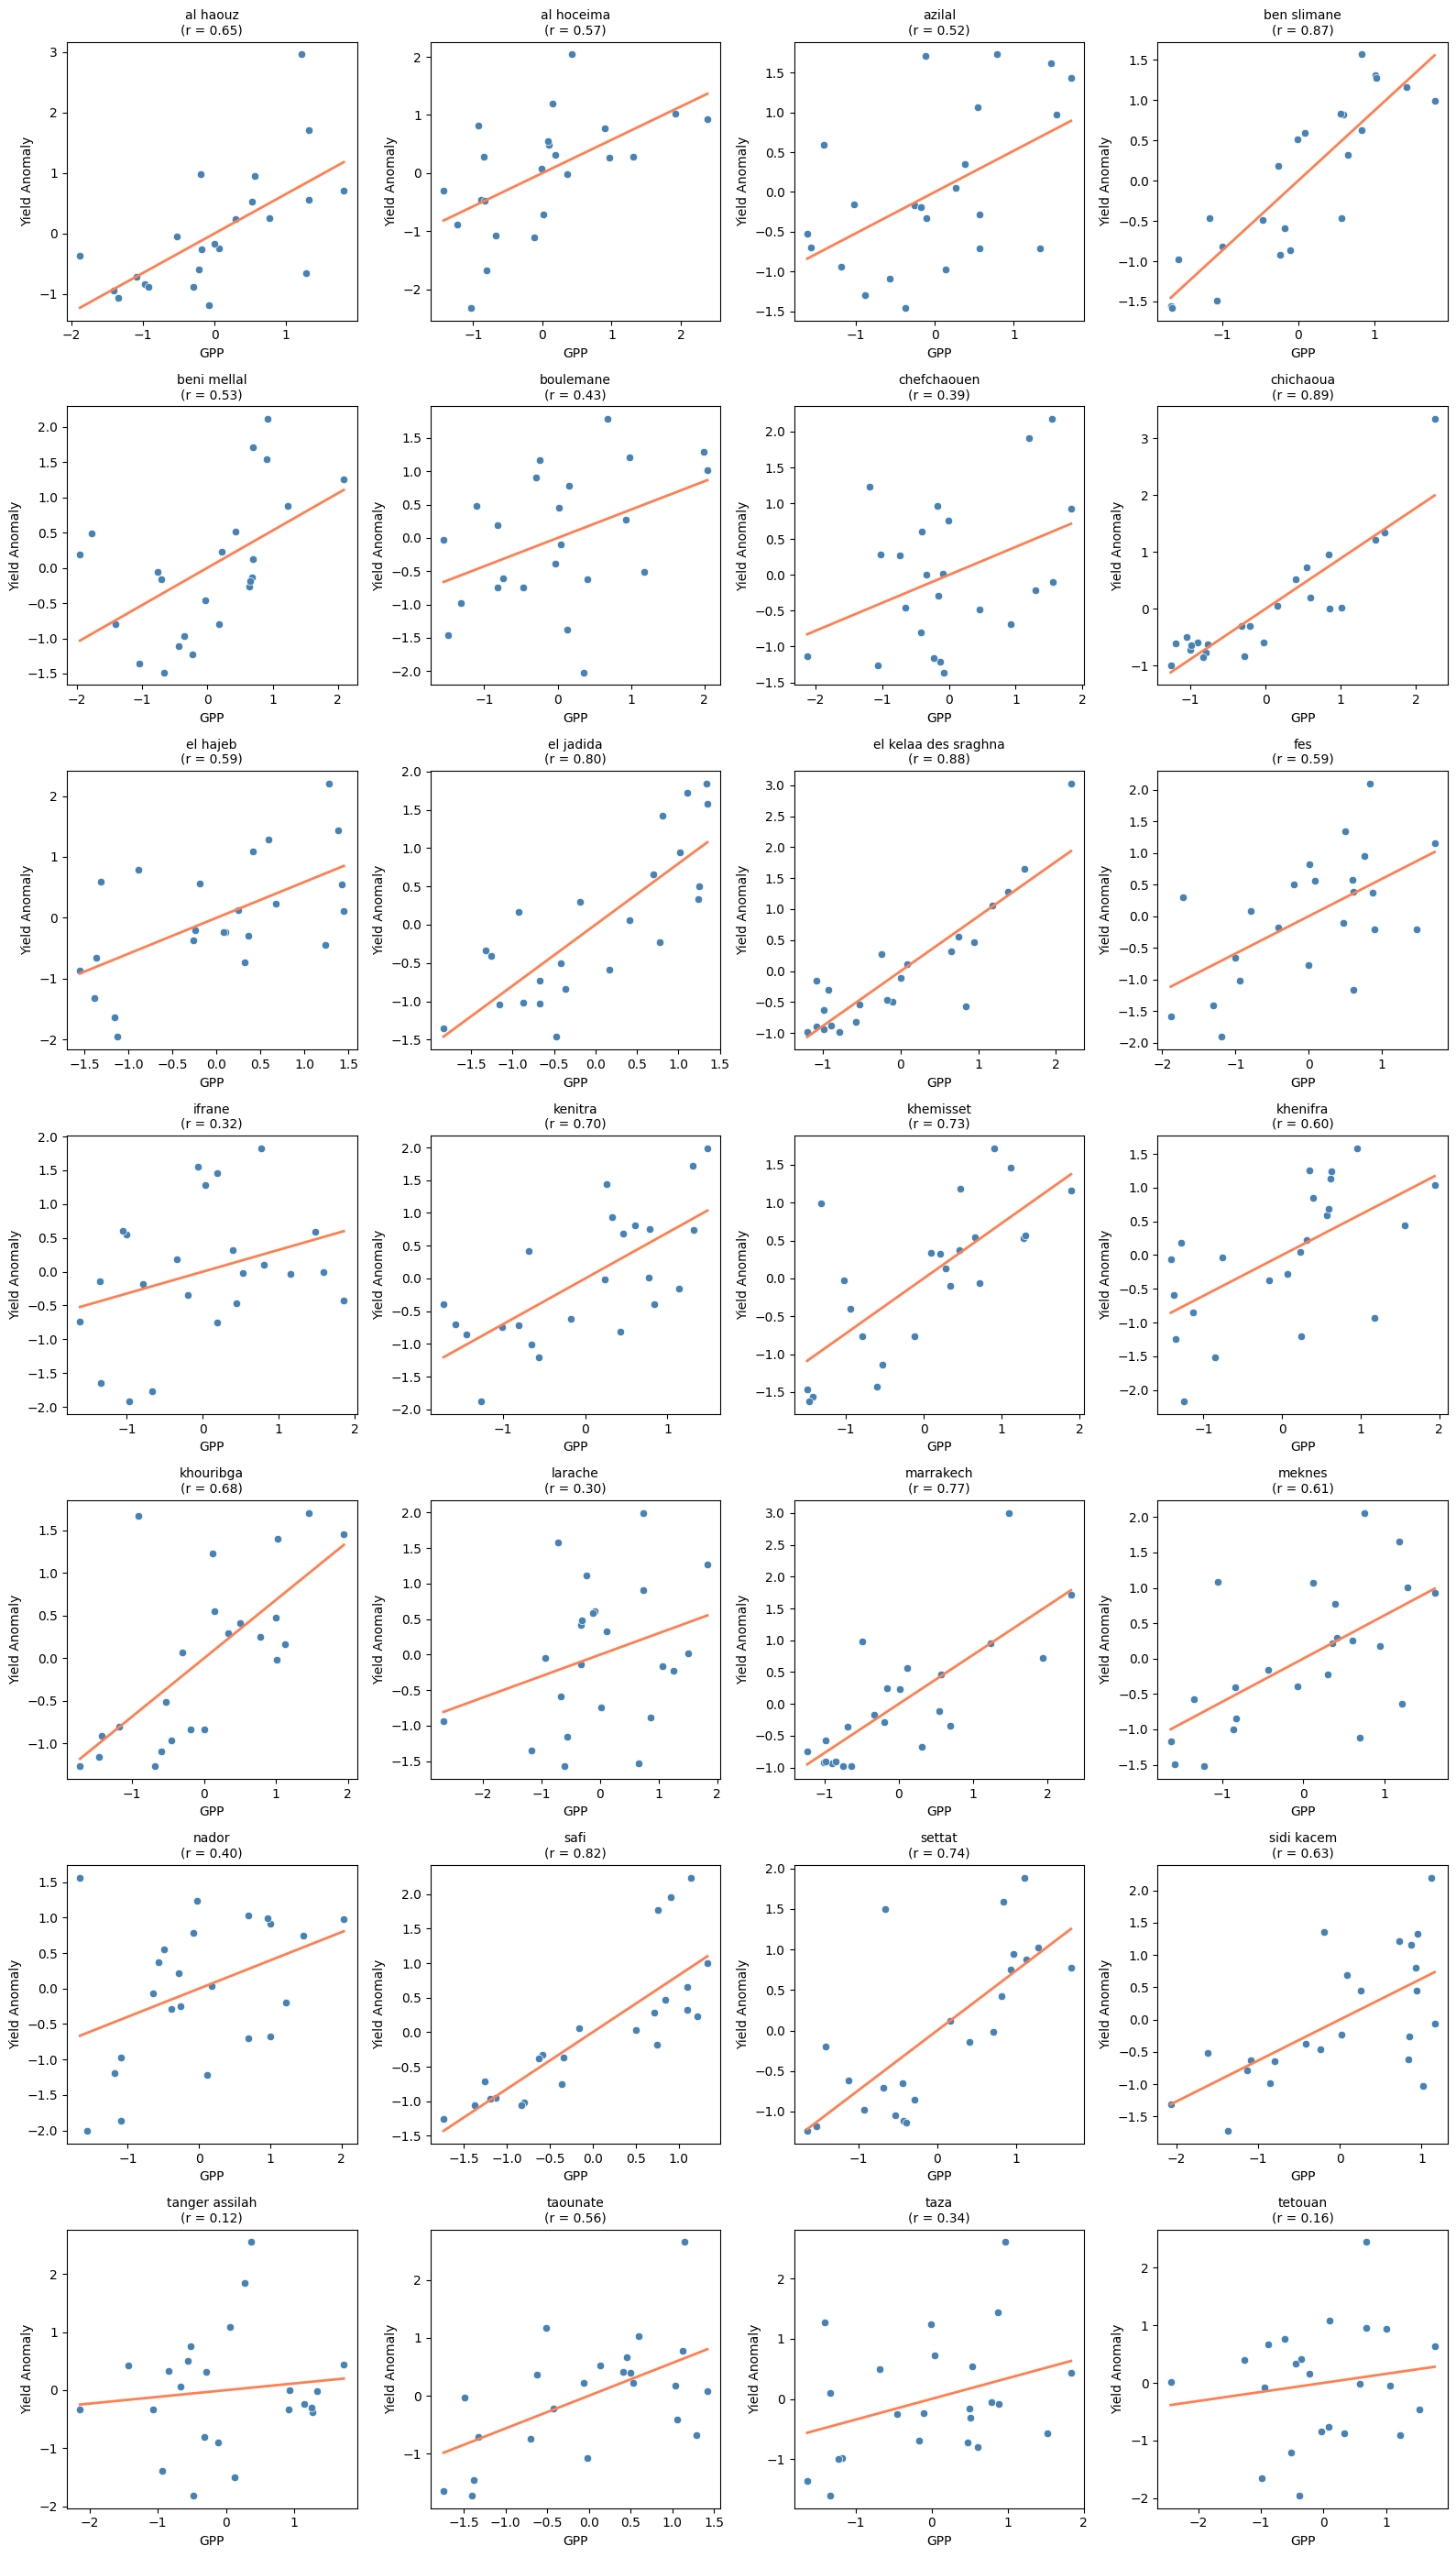

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from unidecode import unidecode
 # 处理特殊字符

# =============================================
# 1. 读取数据并预处理
# =============================================
# 读取 VCI 数据（省份为列，年份为索引）
vci = pd.read_csv("/content/drive/MyDrive/GPP_anomaly_wide_corrected.csv", index_col="Season_Year")

# 读取 Anomaly Yield 数据（省份为列，年份为索引）
anomaly = pd.read_excel("/content/drive/MyDrive/table/Anomaly_Yield_Results.xlsx", index_col="Season_Year")

# **处理省份名称格式**
def clean_province_name(name):
    name = str(name).strip()  # 去除首尾空格
    name = unidecode(name)  # 移除法语、西班牙语等特殊字符（如 é -> e, â -> a）
    name = name.lower().replace("-", " ").replace("'", " ")  # 统一大小写，替换连字符和撇号
    return name

# 统一省份名称格式
vci.columns = [clean_province_name(col) for col in vci.columns]
anomaly.columns = [clean_province_name(col) for col in anomaly.columns]

# **检查省份匹配情况**
common_provinces = set(vci.columns) & set(anomaly.columns)
missing_in_vci = set(anomaly.columns) - set(vci.columns)
missing_in_anomaly = set(vci.columns) - set(anomaly.columns)

print(f"✅ 匹配成功的省份数量: {len(common_provinces)}")
print(f"❌ VCI 中缺少的省份: {missing_in_vci}")
print(f"❌ Anomaly Yield 中缺少的省份: {missing_in_anomaly}")

# 仅保留匹配成功的省份
common_provinces = sorted(common_provinces)
vci = vci[common_provinces]
anomaly = anomaly[common_provinces]

# =============================================
# 2. 计算协方差和相关系数
# =============================================
cov_results = []
corr_results = []

for province in common_provinces:
    combined = pd.DataFrame({
        'VCI': vci[province],
        'Anomaly': anomaly[province]
    }).dropna()

    if not combined.empty:
        covariance = combined.cov().iloc[0, 1]
        correlation = combined.corr().iloc[0, 1]

        cov_results.append({'Province': province, 'Covariance': covariance})
        corr_results.append({'Province': province, 'Correlation': correlation})

cov_df = pd.DataFrame(cov_results)
corr_df = pd.DataFrame(corr_results)

cov_df.to_csv("/content/drive/MyDrive/VCI_Covariance_Results.csv", index=False)
corr_df.to_csv("/content/drive/MyDrive/VCI_Correlation_Results.csv", index=False)

# =============================================
# 3. 绘制散点回归图
# =============================================
num_provinces = len(common_provinces)
cols = 4
rows = (num_provinces // cols) + (num_provinces % cols > 0)

plt.figure(figsize=(4 * cols, 4 * rows))

for i, province in enumerate(common_provinces, 1):
    ax = plt.subplot(rows, cols, i)
    combined = pd.DataFrame({'VCI': vci[province], 'Anomaly': anomaly[province]}).dropna()

    sns.scatterplot(data=combined, x='VCI', y='Anomaly', color='steelblue', ax=ax)

    if not combined.empty:
        slope, intercept, r_value, _, _ = linregress(combined['VCI'], combined['Anomaly'])
        sns.lineplot(x=combined['VCI'], y=slope * combined['VCI'] + intercept, color='coral', linewidth=2, ax=ax)
        ax.set_title(f"{province}\n(r = {r_value:.2f})", fontsize=10)

    ax.set_xlabel("GPP")
    ax.set_ylabel("Yield Anomaly")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/VCI_Scatter_Plots.png", dpi=300)
plt.show()

ＮＤＶＩ用来划分阶段的

In [ ]:
import os
import re
import glob
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterio.mask import mask
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy.signal import savgol_filter

# ---------------------
# 1. 加载摩洛哥省级边界
# ---------------------
shp_path = '/content/drive/MyDrive/shp/final map/MAR.shp'
gdf = gpd.read_file(shp_path)
gdf = gdf.to_crs("EPSG:4326")  # 确保 CRS 与栅格一致

# ---------------------
# 2. 加载 NDVI 文件路径
# ---------------------
ndvi_dir = '/content/drive/MyDrive/GEE_NDVI/'
tif_files = sorted(glob.glob(ndvi_dir + '*.tif'))

# 用正则解析 DOY 文件名中的时间
def extract_date_from_filename(filename):
    match = re.search(r'doy(\d{4})(\d{3})', filename)
    if match:
        year, doy = int(match.group(1)), int(match.group(2))
        return datetime(year, 1, 1) + timedelta(days=doy - 1)
    else:
        return None

# ---------------------
# 3. 循环处理每个栅格文件 → 每省的 NDVI 均值
# ---------------------
records = []

for tif_path in tqdm(tif_files):
    date = extract_date_from_filename(tif_path)
    if date is None:
        continue

    with rasterio.open(tif_path) as src:
        for idx, row in gdf.iterrows():
            geom = [row['geometry']]
            try:
                out_image, out_transform = mask(src, geom, crop=True)
                ndvi_data = out_image[0]
                ndvi_data = ndvi_data.astype(float)
                ndvi_data[ndvi_data == src.nodata] = np.nan

                # MODIS NDVI scale factor = 0.0001
                ndvi_data = ndvi_data * 0.0001
                mean_ndvi = np.nanmean(ndvi_data)

                records.append({
                    'Province': row['NAME_2'],
                    'Year': date.year,
                    'Month': date.month,
                    'NDVI': mean_ndvi
                })

            except Exception as e:
                print(f"Error in {tif_path} - {row['NAME_2']}: {e}")
                continue

# ---------------------
# 4. 保存 NDVI 表格
# ---------------------
ndvi_df = pd.DataFrame(records)
ndvi_df = ndvi_df.dropna()
ndvi_df.to_csv('/content/province_monthly_ndvi.csv', index=False)


100%|██████████| 286/286 [01:06<00:00,  4.28it/s]


In [ ]:
# 载入上一步结果
df = pd.read_csv('/content/province_monthly_ndvi.csv')

results = []

for (province, year), group in tqdm(df.groupby(['Province', 'Year'])):
    ndvi_series = group.sort_values('Month')['NDVI'].values

    if len(ndvi_series) != 12 or np.isnan(ndvi_series).any():
        continue

    ndvi_smooth = savgol_filter(ndvi_series, window_length=5, polyorder=2)
    derivative = np.gradient(ndvi_smooth)

    sos_idx = np.argmax(derivative[:8])  # SOS（最大增长）
    peak_idx = np.argmax(ndvi_smooth)    # Peak（最高值）
    eos_idx = peak_idx + np.argmax(derivative[peak_idx:] < -0.01) if peak_idx < 11 else 11

    results.append({
        'Province': province,
        'Year': year,
        'SOS_Month': sos_idx + 1,
        'Peak_Month': peak_idx + 1,
        'EOS_Month': eos_idx + 1,
        'Early_Phase': f'1-{sos_idx + 1}',
        'Mid_Phase': f'{sos_idx + 1}-{eos_idx + 1}',
        'Late_Phase': f'{eos_idx + 1}-12',
    })

output_df = pd.DataFrame(results)
output_df.to_csv('/content/ndvi_phenology_stage.csv', index=False)


100%|██████████| 672/672 [00:00<00:00, 1409.91it/s]
